In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

In [3]:
bike_hourly = pd.read_csv('hourly_weather.csv')

**Data Wrangling** 

In [4]:
#create a copy of the bike hourly data
bike_hourly_new = bike_hourly.copy()

In [5]:
bike_hourly_new.head()

,Casual,Date,Hour,Member,Total_rides,relativehumidity_2m (%),temperature_2m (°C),weathercode (wmo code),windspeed_10m (km/h)
0,20.0,2021-01-01,0,26.0,46.0,90,2.4,1,10.2
1,23.0,2021-01-01,1,23.0,46.0,88,1.8,1,10.0
2,20.0,2021-01-01,2,28.0,48.0,87,1.1,2,10.1
3,9.0,2021-01-01,3,7.0,16.0,81,1.6,2,10.6
4,7.0,2021-01-01,4,5.0,12.0,77,1.6,2,9.9


In [6]:
# Convert the 'Date' column to datetime
bike_hourly_new['Date'] = pd.to_datetime(bike_hourly_new['Date'])

# Ensure 'Hour' is integer (if it's not already)
bike_hourly_new['Hour'] = bike_hourly_new['Hour'].astype(int)

# Convert float columns correctly
float_columns = ['Casual', 'Member', 'Total_rides', 'temperature_2m (°C)', 'windspeed_10m (km/h)']
bike_hourly_new[float_columns] = bike_hourly_new[float_columns].astype(float)

# Convert integer columns
int_columns = ['relativehumidity_2m (%)', 'weathercode (wmo code)']
bike_hourly_new[int_columns] = bike_hourly_new[int_columns].astype(int)

#adding month_year as a column
bike_hourly_new['month_year'] = bike_hourly_new['Date'].dt.strftime('%Y-%m')

#convert month year to datetime
bike_hourly_new['month_year'] = pd.to_datetime(bike_hourly_new['month_year'])

#have a year column
bike_hourly_new['year'] = bike_hourly_new['Date'].dt.year

# Check the updated data types
print(bike_hourly_new.dtypes)


Casual                            float64
Date                       datetime64[ns]
Hour                                int64
Member                            float64
Total_rides                       float64
relativehumidity_2m (%)             int64
temperature_2m (°C)               float64
weathercode (wmo code)              int64
windspeed_10m (km/h)              float64
month_year                 datetime64[ns]
year                                int32
dtype: object


In [7]:
#change the columns to lowercase and remove spaces
bike_hourly_new.columns = bike_hourly_new.columns.str.lower().str.replace(' ', '_')
bike_hourly_new.head()

,casual,date,hour,member,total_rides,relativehumidity_2m_(%),temperature_2m_(°c),weathercode_(wmo_code),windspeed_10m_(km/h),month_year,year
0,20.0,2021-01-01,0,26.0,46.0,90,2.4,1,10.2,2021-01-01,2021
1,23.0,2021-01-01,1,23.0,46.0,88,1.8,1,10.0,2021-01-01,2021
2,20.0,2021-01-01,2,28.0,48.0,87,1.1,2,10.1,2021-01-01,2021
3,9.0,2021-01-01,3,7.0,16.0,81,1.6,2,10.6,2021-01-01,2021
4,7.0,2021-01-01,4,5.0,12.0,77,1.6,2,9.9,2021-01-01,2021


**Feature Enginnering**

In [8]:
#adding holiday as a column
cal = calendar()
holidays = cal.holidays(start=bike_hourly_new['date'].min(), end=bike_hourly_new['date'].max())
bike_hourly_new['holiday'] = bike_hourly_new['date'].isin(holidays)

#add month and day of the week as columns
bike_hourly_new['month'] = bike_hourly_new['date'].dt.month
bike_hourly_new['day_of_week'] = bike_hourly_new['date'].dt.dayofweek

#adding season as a column
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

bike_hourly_new['season'] = bike_hourly_new['date'].dt.month.apply(get_season)

#adding holiday as a column
cal = calendar()
holidays = cal.holidays(start=bike_hourly_new['date'].min(), end=bike_hourly_new['date'].max())
bike_hourly_new['holiday'] = bike_hourly_new['date'].isin(holidays)

#change season to a category
bike_hourly_new['season'] = bike_hourly_new['season'].astype('category')

#adding month_year as a column
bike_hourly_new['month_year'] = pd.to_datetime(bike_hourly_new['date']).dt.to_period('M')



In [9]:
#change data type from integer to category for day of the week
bike_hourly_new['day_of_week'] = bike_hourly_new['day_of_week'].astype('category')

#change data type from integer to category for month
bike_hourly_new['month'] = bike_hourly_new['month'].astype('category')

#change the day of the week to actual names
bike_hourly_new['day_of_week'] = bike_hourly_new['day_of_week'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

#change the month to actual names
bike_hourly_new['month'] = bike_hourly_new['month'].map({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'})

#change the holiday column to yes or no
bike_hourly_new['holiday'] = bike_hourly_new['holiday'].map({True: 'Yes', False: 'No'})

#change the hour to a early morning, morning, afternoon, evening, or night
def get_time_of_day(hour):
    if hour in [0, 1, 2, 3, 4, 5]:
        return 'Early Morning'
    elif hour in [6, 7, 8, 9, 10, 11]:
        return 'Morning'
    elif hour in [12, 13, 14, 15, 16, 17]:
        return 'Afternoon'
    elif hour in [18, 19, 20, 21, 22, 23]:
        return 'Evening'
    
bike_hourly_new['time_of_day'] = bike_hourly_new['hour'].apply(get_time_of_day)



# Define bin edges and labels based on WMO weather codes
bins = [0, 4, 20, 40, 50, 60, 70, 80, 90, 100]
labels = [
    "Clear/Cloudy", 
    "Atmospheric Obstructions", 
    "Fog Conditions", 
    "Drizzle", 
    "Rain", 
    "Snow", 
    "Showers", 
    "Thunderstorms",
    "Extreme Weather"
]

# Define humidity bins and labels
humidity_bins = [0, 30, 60, 80, 100]
humidity_labels = ['Low', 'Moderate', 'High', 'Very High']

# Define windspeed bins and labels
windspeed_bins = [0, 5, 20, 39, 61, float('inf')]
windspeed_labels = ['Calm', 'Light Breeze', 'Moderate Breeze', 'Strong Breeze', 'High Wind']

# Ensure the columns are numeric before processing
bike_hourly_new['relativehumidity_2m_(%)'] = pd.to_numeric(bike_hourly_new['relativehumidity_2m_(%)'], errors='coerce')
bike_hourly_new['windspeed_10m_(km/h)'] = pd.to_numeric(bike_hourly_new['windspeed_10m_(km/h)'], errors='coerce')
bike_hourly_new['weathercode_(wmo_code)'] = pd.to_numeric(bike_hourly_new['weathercode_(wmo_code)'], errors='coerce')

# Apply binning to relevant columns
bike_hourly_new['weather_category'] = pd.cut(
    bike_hourly_new['weathercode_(wmo_code)'], 
    bins=bins, 
    labels=labels, 
    right=False, 
    include_lowest=True
)

bike_hourly_new['humidity_category'] = pd.cut(
    bike_hourly_new['relativehumidity_2m_(%)'], 
    bins=humidity_bins, 
    labels=humidity_labels, 
    right=True, 
    include_lowest=True
)

bike_hourly_new['windspeed_category'] = pd.cut(
    bike_hourly_new['windspeed_10m_(km/h)'], 
    bins=windspeed_bins, 
    labels=windspeed_labels, 
    right=True, 
    include_lowest=True
)

# Display results
print(bike_hourly_new[['windspeed_10m_(km/h)', 'windspeed_category']].head())

# Display results
print(bike_hourly_new[['relativehumidity_2m_(%)', 'humidity_category']].head())



   windspeed_10m_(km/h) windspeed_category
0                  10.2       Light Breeze
1                  10.0       Light Breeze
2                  10.1       Light Breeze
3                  10.6       Light Breeze
4                   9.9       Light Breeze
   relativehumidity_2m_(%) humidity_category
0                       90         Very High
1                       88         Very High
2                       87         Very High
3                       81         Very High
4                       77              High


In [10]:
#filling the null values with the mean of the column for casual and member and total rides and windspeed
bike_hourly_new['casual'] = bike_hourly_new['casual'].fillna(bike_hourly_new['casual'].mean())
bike_hourly_new['member'] = bike_hourly_new['member'].fillna(bike_hourly_new['member'].mean())
bike_hourly_new['total_rides'] = bike_hourly_new['total_rides'].fillna(bike_hourly_new['total_rides'].mean())



In [11]:
bike_hourly_new.head()

,casual,date,hour,member,total_rides,relativehumidity_2m_(%),temperature_2m_(°c),weathercode_(wmo_code),windspeed_10m_(km/h),month_year,year,holiday,month,day_of_week,season,time_of_day,weather_category,humidity_category,windspeed_category
0,20.0,2021-01-01,0,26.0,46.0,90,2.4,1,10.2,2021-01,2021,Yes,January,Friday,Winter,Early Morning,Clear/Cloudy,Very High,Light Breeze
1,23.0,2021-01-01,1,23.0,46.0,88,1.8,1,10.0,2021-01,2021,Yes,January,Friday,Winter,Early Morning,Clear/Cloudy,Very High,Light Breeze
2,20.0,2021-01-01,2,28.0,48.0,87,1.1,2,10.1,2021-01,2021,Yes,January,Friday,Winter,Early Morning,Clear/Cloudy,Very High,Light Breeze
3,9.0,2021-01-01,3,7.0,16.0,81,1.6,2,10.6,2021-01,2021,Yes,January,Friday,Winter,Early Morning,Clear/Cloudy,Very High,Light Breeze
4,7.0,2021-01-01,4,5.0,12.0,77,1.6,2,9.9,2021-01,2021,Yes,January,Friday,Winter,Early Morning,Clear/Cloudy,High,Light Breeze


**Corelation Matrix**

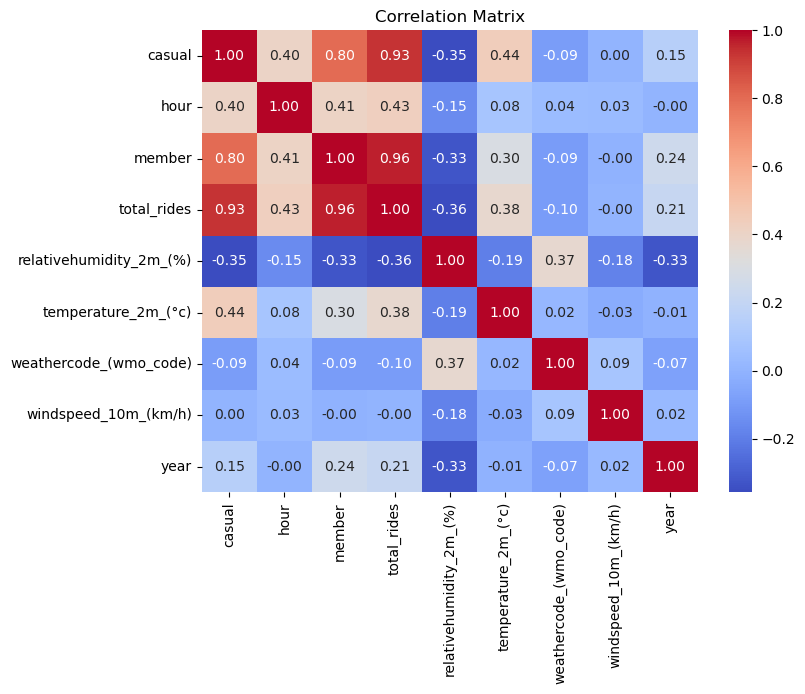

In [12]:
#selecting only the columns that are numeric for the correlation matrix
numeric_columns = bike_hourly_new.select_dtypes(include=[np.number]).columns

#creating a correlation matrix
correlation_matrix = bike_hourly_new[numeric_columns].corr()

#generating a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

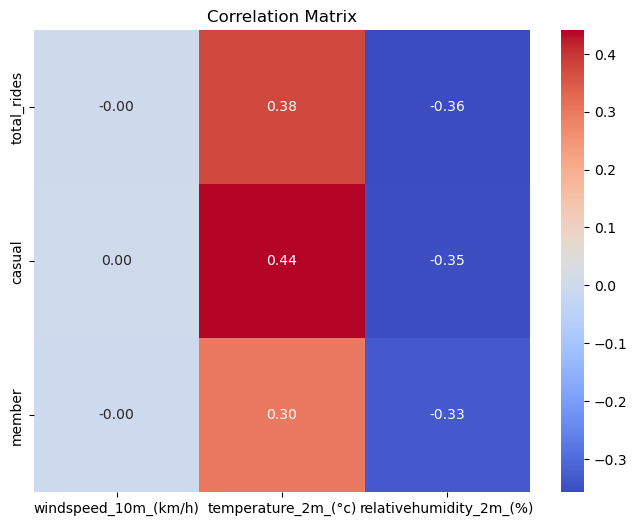

In [13]:
#numerical columns that are related to total rides, casual, and member
numeric_columns = ['casual', 'member', 'total_rides', 'temperature_2m_(°c)', 'relativehumidity_2m_(%)', 'windspeed_10m_(km/h)']
correlation_matrix = bike_hourly_new[numeric_columns].corr()

#extract the correlation of total rides with casual and member
correlation_total_rides = correlation_matrix.loc[['total_rides','casual','member'],['windspeed_10m_(km/h)', 'temperature_2m_(°c)', 'relativehumidity_2m_(%)']]
correlation_total_rides

#generating a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_total_rides, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# ML for Membership

## Basic Linear with Univariate 

In [14]:
#prepare the data
X = bike_hourly_new[['temperature_2m_(°c)']]
y = bike_hourly_new['member']

#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)

#make predictions
predictions = model.predict(X_test)



Mean Squared Error (MSE): 46404.157631024886
R^2 Score: 0.0919683119080631


## Basic Linear with Multivariate  

In [15]:
#prepare the data for mutivariate linear regression
X1 = bike_hourly_new[['temperature_2m_(°c)', 'relativehumidity_2m_(%)', 'windspeed_10m_(km/h)']]
y1 = bike_hourly_new['member']

#split the data
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)

#make predictions
predictions = model.predict(X_test)

# # Step 7: Visualize the results
# plt.scatter(X_test, y_test, color='blue', label='Actual')
# plt.plot(X_test, predictions, color='red', label='Predicted')
# plt.xlabel('Independent Variable')
# plt.ylabel('Dependent Variable')
# plt.legend()
# plt.show()



Mean Squared Error (MSE): 42343.43792003396
R^2 Score: 0.17142804918759635


In [16]:
#prepare the data for polynomial regression
X2 = bike_hourly_new[['temperature_2m_(°c)', 'relativehumidity_2m_(%)', 'windspeed_10m_(km/h)']]
y2 = bike_hourly_new['member']

#split the data
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Create a linear regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Evaluate the model
y_pred = model.predict(X_test_poly)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#make predictions
predictions = model.predict(X_test_poly)

print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)


Mean Squared Error (MSE): 40239.56151719684
R^2 Score: 0.21259648191285152


## Random Forest for Members


In [17]:
# Prepare the data for Random Forest regression
X3 = bike_hourly_new[['holiday', 'month', 'day_of_week', 'season', 'time_of_day', 'weather_category', 'humidity_category', 'windspeed_category']]
y3 = bike_hourly_new['member']

# Encode categorical variables
X3_encoded = pd.get_dummies(X3, drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X3_encoded, y3, test_size=0.2, random_state=42)

# Create the random forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Make predictions
predictions = model.predict(X_test)

print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)

# Display Actual vs Predicted Values with Date and Hour
comparison_df = pd.DataFrame({
    'Month': bike_hourly_new.loc[X_test.index, 'month'].values,
    'Actual Member Trips': y_test.values,
    'Predicted Member Trips': y_pred
})

print(comparison_df.head(10))  # Display first 10 comparisons


Mean Squared Error (MSE): 24908.949451563156
R^2 Score: 0.5125842904219081
       Month  Actual Member Trips  Predicted Member Trips
0      April                510.0              442.457691
1  September                370.0              276.270741
2   November                299.0              193.626502
3   November                 15.0               14.139319
4     August                445.0              350.867857
5     August               1118.0              651.405508
6        May                185.0              300.092611
7        May                325.0              287.986357
8       July                 67.0               23.575507
9   February                 40.0               10.433354


## RandomForest for Casual

In [18]:
# Prepare the data for Random Forest regression
X4 = bike_hourly_new[['holiday', 'month', 'day_of_week', 'season', 'time_of_day', 'weather_category', 'humidity_category', 'windspeed_category']]
y4 = bike_hourly_new['casual']

# Encode categorical variables
X4_encoded = pd.get_dummies(X4, drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X4_encoded, y4, test_size=0.2, random_state=42)

# Create the random forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Make predictions
predictions = model.predict(X_test)

print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)

# Display Actual vs Predicted Values with Date and Hour
comparison_df = pd.DataFrame({
    'Time of the Day': bike_hourly_new.loc[X_test.index, 'time_of_day'].values,
    'Actual casual Trips': y_test.values,
    'Predicted casual Trips': y_pred
})

print(comparison_df.head(10))  # Display first 10 comparisons


Mean Squared Error (MSE): 9096.689843467491
R^2 Score: 0.66814376607842
  Time of the Day  Actual casual Trips  Predicted casual Trips
0       Afternoon                713.0              577.737814
1         Morning                138.0              171.365342
2         Evening                118.0              118.435358
3   Early Morning                  1.0                7.269987
4       Afternoon                198.0              158.018333
5         Evening                643.0              413.230778
6         Morning                 59.0              109.430244
7       Afternoon                244.0              227.085762
8   Early Morning                 20.0               11.922464
9   Early Morning                 16.0                4.265457


## Polynomial for Casual

In [19]:
# Prepare the data for Polynomial Regression
X5 = bike_hourly_new[['holiday', 'month', 'day_of_week', 'season', 'time_of_day', 'weather_category', 'humidity_category', 'windspeed_category']]
y5 = bike_hourly_new['casual']

# Encode categorical variables
X5_encoded = pd.get_dummies(X5, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X5_encoded, y5, test_size=0.2, random_state=42)

# Apply Polynomial Features (degree = 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Create and train the Polynomial Regression model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Make predictions
y_pred = poly_model.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display results
print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)

Mean Squared Error (MSE): 9178.888717614702
R^2 Score: 0.6651450699288887


## Polyinomial for Member 

In [26]:
# Prepare the data for Polynomial Regression
X7 = bike_hourly_new[['holiday', 'month', 'day_of_week', 'season', 'time_of_day', 'weather_category', 'humidity_category', 'windspeed_category']]
y7 = bike_hourly_new['member']

# Encode categorical variables
X7_encoded = pd.get_dummies(X7, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X7_encoded, y7, test_size=0.2, random_state=42)

# Apply Polynomial Features (degree = 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Create and train the Polynomial Regression model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Make predictions
y_pred = poly_model.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display results
print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)

Mean Squared Error (MSE): 23843.805045835514
R^2 Score: 0.533426924404944


# Model Improvement for Member 

## RandomForest + Grid Search

In [24]:
# Prepare the data for Random Forest regression
X3 = bike_hourly_new[['holiday', 'month', 'day_of_week', 'season', 'time_of_day', 'weather_category', 'humidity_category', 'windspeed_category']]
y3 = bike_hourly_new['member']

# Encode categorical variables
X3_encoded = pd.get_dummies(X3, drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X3_encoded, y3, test_size=0.2, random_state=42)

# Grid Search CV for Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                            param_grid=param_grid,
                            cv=3,
                            verbose=1,
                            n_jobs=-1,
                            scoring='r2')

# Fit the model
grid_search.fit(X_train, y_train)

# Best estimator
best_model = grid_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)

# Display Actual vs Predicted Values with Date and Hour
comparison_df = pd.DataFrame({
    'Month': bike_hourly_new.loc[X_test.index, 'month'].values,
    'Actual Member Trips': y_test.values,
    'Predicted Member Trips': y_pred
})

print(comparison_df.head(10))  # Display first 10 comparisons


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mean Squared Error (MSE): 23933.81964698387
R^2 Score: 0.5316655281334381
       Month  Actual Member Trips  Predicted Member Trips
0      April                510.0              426.508242
1  September                370.0              328.777129
2   November                299.0              274.951784
3   November                 15.0               24.732023
4     August                445.0              404.096634
5     August               1118.0              491.422483
6        May                185.0              320.551383
7        May                325.0              362.467211
8       July                 67.0               22.889763
9   February                 40.0               11.740089


## Polynomial + Randomsearch CV

In [25]:
# Step 1: Prepare the data
X6 = bike_hourly_new[['holiday', 'month', 'day_of_week', 'season', 
                      'time_of_day', 'weather_category', 
                      'humidity_category', 'windspeed_category']]
y6 = bike_hourly_new['member']

# Step 2: Encode categorical variables
X6_encoded = pd.get_dummies(X6, drop_first=True)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X6_encoded, y6, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Step 4: Create a Pipeline (PolynomialFeatures + Ridge Regression)
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('ridge_reg', Ridge())
])

# Step 5: Set up the hyperparameter grid for Randomized Search
param_grid = {
    'poly_features__degree': [1, 2, 3],    # Limited to 3 degrees for faster tuning
    'ridge_reg__alpha': [0.1, 1, 10]       # Fewer alpha values
}

# Step 6: Perform Randomized Search with Cross-Validation (3-fold for speed)
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, 
                                   n_iter=5, cv=3, scoring='r2', random_state=42)

# Step 7: Train on a smaller sample for quicker execution
X_sample = X_train.sample(frac=0.5, random_state=42)  # Use 50% of training data
y_sample = y_train.loc[X_sample.index]

# Step 8: Fit the model
random_search.fit(X_sample, y_sample)

# Step 9: Get the best model and hyperparameters
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Step 10: Make predictions with the best model
y_pred = best_model.predict(X_test)

# Step 11: Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 12: Display results
print("Best Hyperparameters:", best_params)
print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)

Best Hyperparameters: {'ridge_reg__alpha': 10, 'poly_features__degree': 2}
Mean Squared Error (MSE): 24144.535678879798
R^2 Score: 0.5275422589282974


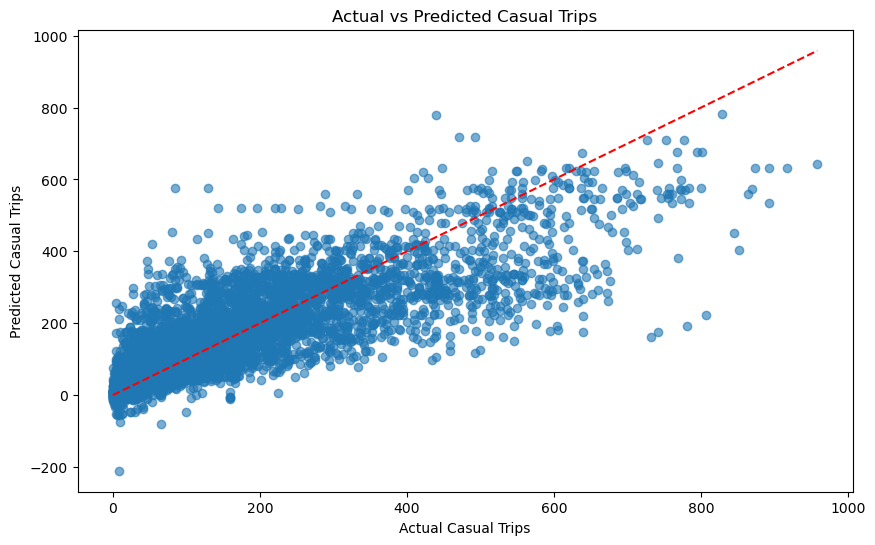

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Casual Trips')
plt.ylabel('Predicted Casual Trips')
plt.title('Actual vs Predicted Casual Trips')
plt.show()

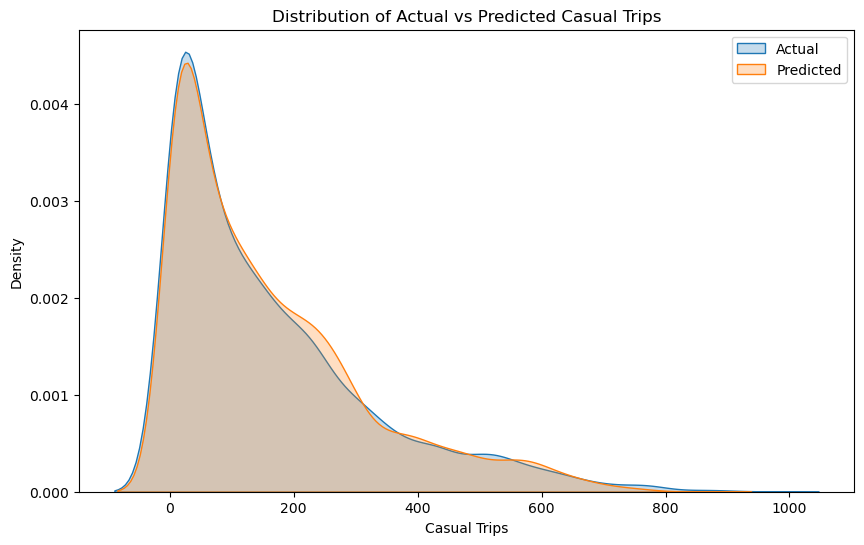

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Actual', fill=True)   # Replaced shade=True with fill=True
sns.kdeplot(y_pred, label='Predicted', fill=True)

plt.xlabel('Casual Trips')
plt.title('Distribution of Actual vs Predicted Casual Trips')
plt.legend()
plt.show()